### Setup

Import all relevant libraries.

In [30]:
import numpy as np
import tensorflow as tf
import keras

import os
import datetime
import time as timer
import sys
import imp

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import models as M
import utils as U

imp.reload(M)
imp.reload(U)


/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_28905/2889547795.py:9: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


<module 'utils' from '/Users/mghifary/Work/Code/AI/keras-poc/utils.py'>

### Constants

Some predefined constants to configure the data, model, and training settings.

In [31]:
EPOCH = 30
BATCH = 128

DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODELDIR = "/Users/mghifary/Work/Code/AI/models"

### Load dataset

In [32]:
data_path = os.path.join(DATADIR, "mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(data_path)
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1)


ds_train = tf.data.Dataset.from_tensor_slices(mnist_digits)
ds_train = ds_train.shuffle(buffer_size=1024).batch(BATCH)


In [9]:
# for i, samples in enumerate(ds_train.take(6)):
#     print(type(samples) is tuple)
#     print(np.min(samples), np.max(samples))

False
0.0 1.0
False
0.0 1.0
False
0.0 1.0
False
0.0 1.0
False
0.0 1.0
False
0.0 1.0


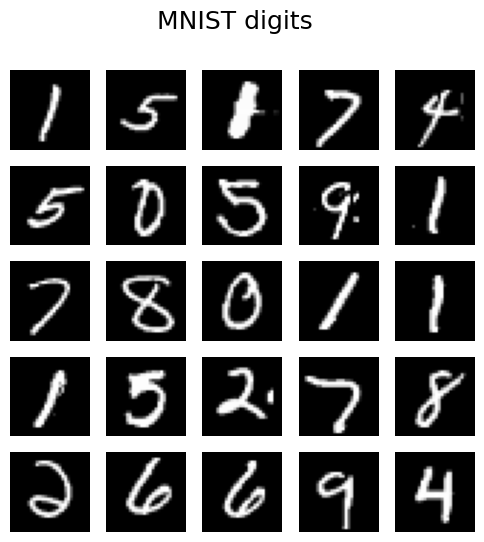

In [33]:
# Visualize dataset
U.visualize_dataset(ds_train, "MNIST digits", n_samples=25)

### Train VAE

In [ ]:
# Setup summary writers for tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/vae-mnist/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [ ]:
latent_dim = 2
encoder = M.create_conv_encoder(input_shape=(28, 28, 1), latent_dim=latent_dim)
decoder = M.create_conv_decoder(latent_dim=latent_dim)
model = M.VAE(encoder, decoder)

optimizer = keras.optimizers.legacy.Adam(3e-4)
modelpath = os.path.join(MODELDIR, "vae-conv_mnist.h5")

model.build(input_shape=(None, 28, 28, 1))

In [ ]:
model.encoder.summary()

In [ ]:
model.decoder.summary()

In [ ]:
model.summary()

In [ ]:
# Training on batch function
@tf.function
def train_vae_on_batch(model, optimizer, inputs):
    with tf.GradientTape() as tape:
        z_mean, z_log_var, z = model.encoder(inputs, training=True)
        reconstruction = model.decoder(z, training=True)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(inputs, reconstruction), axis=(1 , 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        
    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    model.total_loss_tracker.update_state(total_loss)
    model.reconstruction_loss_tracker.update_state(reconstruction_loss)
    model.kl_loss_tracker.update_state(kl_loss)

In [ ]:
# Do training
for epoch in range(EPOCH):
    # Mini-batch training
    train_duration = 0.0
    for step, x in enumerate(ds_train):
        start_t = timer.time()
        train_vae_on_batch(model, optimizer, x)
        elapsed_t = timer.time() - start_t

        train_duration += elapsed_t

    tloss = model.total_loss_tracker.result()
    rloss = model.reconstruction_loss_tracker.result()
    klloss = model.kl_loss_tracker.result()

    
    # Store log
    with train_summary_writer.as_default():
        tf.summary.scalar('total_loss', tloss, step=epoch)
        tf.summary.scalar('reconstruction_loss', rloss, step=epoch)
        tf.summary.scalar('kl_loss', klloss, step=epoch)

    print(f"Epoch {epoch+1} - Training [total_loss: {tloss:.5f}, reconstruction_loss: {rloss:.5f}, kl_loss: {klloss:.5f}] ({train_duration:.3f} secs)")

    # Save model
    model.save_weights(modelpath, overwrite=True, save_format=None, options=None)